In [5]:
%cd ~/fur/
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
shift_03_16_2020 = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift_03_16_2020.get_waveforms_dir()
results_dir = shift_03_16_2020.get_results_dir()

/home/ilobach/fur


In [6]:
res_df_FLAT = pd.read_csv(results_dir.fi("res_df_comb_filter_no_nd_filters_FLAT_data_03_16_2020.csv"))
res_df_ROUND = pd.read_csv(results_dir.fi("res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv"))
res_df_ROUND_Low_RF = pd.read_csv(results_dir.fi("res_df_comb_filter_no_nd_filters_ROUND_low_RF_Voltage_data_03_16_2020.csv"))

In [7]:
alpha = 1.6e-19/2e-12*np.sqrt(2)/4
alpha

2.8284271247461904e-08

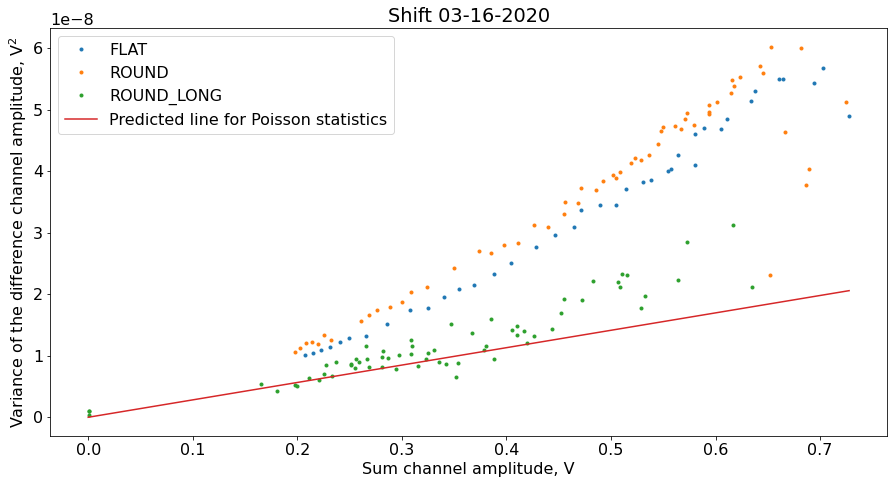

In [11]:
plt.plot(res_df_FLAT["ch2_amplitude"],res_df_FLAT["var_of_ch1_amplitude"] ,'.', label="FLAT")
plt.plot(res_df_ROUND["ch2_amplitude"],res_df_ROUND["var_of_ch1_amplitude"] ,'.', label="ROUND")
plt.plot(res_df_ROUND_Low_RF["ch2_amplitude"],res_df_ROUND_Low_RF["var_of_ch1_amplitude"] ,'.', label="ROUND_LONG")
x_f = np.linspace(0,max(res_df_FLAT["ch2_amplitude"]),1000)
plt.plot(x_f, alpha*x_f, label="Predicted line for Poisson statistics")
plt.xlabel("Sum channel amplitude, V")
plt.ylabel("Variance of the difference channel amplitude, V$^2$")
plt.title(r"Shift 03-16-2020")
plt.legend()
plt.savefig(results_dir.fi("no_nd_filters_variable_beam_current.png"), bbox_inches='tight')
plt.show()